# Evaluation of distributions 

In this notebook, we will conduct the evaluation of the distributions. 
We will begin with a heatmap that aims to represent the distributions for the different models.

In [1]:
import glob, json, os
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from typing import Dict, List, Tuple

# EVAL_DIR = "../evals/results-0shot/histogram_greedy"
EVAL_DIR = "../evals/results-2shot/json/histogram_greedy/all"
# EVAL_DIR = "../evals/results-2shot/json/histogram_richer/all"
PLOTS_PATH = lambda name: f"{EVAL_DIR}/analysis/plots/{name}"
# ============================================================
#                 Default (VISUAL) configurations
# =====================================88=======================
from matplotlib.ticker import MultipleLocator, PercentFormatter
FULL_WIDTH, FULL_HEIGHT = 6.30045, 3.03209
DEF_SIZE = FULL_WIDTH, FULL_HEIGHT

pd.set_option('display.max_colwidth', 100)

# Accessibility
sns.set_palette(sns.color_palette("colorblind"))
matplotlib.rcParams["axes.prop_cycle"] = matplotlib.cycler(color=sns.color_palette("colorblind"))

# Put at top of plotting script (requires tex be installed though)
matplotlib.rc('font', family='serif', size=12)
matplotlib.rc('text', usetex=True)


def adjust(fig, left=0.0, right=1.0, bottom=0.0, top=1.0, wspace=0.0, hspace=0.0):
    fig.subplots_adjust(
        left   = left,  # the left side of the subplots of the figure
        right  = right,  # the right side of the subplots of the figure
        bottom = bottom,  # the bottom of the subplots of the figure
        top    = top,  # the top of the subplots of the figure
        wspace = wspace,  # the amount of width reserved for blank space between subplots
        hspace = hspace,  # the amount of height reserved for white space between subplots
    )
    
def save_fig(fig, path, **kwargs):
    os.makedirs(path.rpartition("/")[0], exist_ok=True)
    path = path.replace(".json", "")
    fig.savefig(path, bbox_inches="tight", **kwargs)


def read_json(path: str) -> dict:
    with open(path, "r") as f:
        return json.load(f)


def print_sep(*msgs):
    print("+" * 80)
    print(*msgs)
    print("+" * 80)

## Evaluate histograms (visually)

In [2]:
EXPR_ORDER = [
    # 'control',
    "almost certain",
    "highly likely",
    "very likely",
    "likely",
    "probable",
    "somewhat likely",
    "possible",
    "uncertain", 
    'somewhat unlikely',
    "unlikely",
    "not likely",
    "doubtful",
    "very unlikely",
    "highly unlikely",
]

In [31]:
from metrics import get_statistics_per_distribution

def histogram_to_dataframe(expr_histograms: dict, order=EXPR_ORDER, statistic=None) -> pd.DataFrame:
    results = defaultdict(list)
    statistic_mask = defaultdict(list)
    
    if order is not None:
        expr_histograms = {e: expr_histograms[e] for e in order if e in expr_histograms}

    for expression, hist in expr_histograms.items():
        results["uncertainty_expression"].append(expression)
        statistic_mask["uncertainty_expression"].append(expression)
        
        for bin_name, bin_value in hist.items():
            if bin_name in ("-1", -1):
                continue
            results[round(float(bin_name))].append(bin_value)
            if statistic and statistic[expression] == bin_name:
                statistic_mask[round(float(bin_name))].append(1)
            else:
                statistic_mask[round(float(bin_name))].append(0)
    return (pd.DataFrame(results).set_index("uncertainty_expression"), 
            pd.DataFrame(statistic_mask).set_index("uncertainty_expression"))


def plot_histogram(data: dict, statistic="median", figsize=(FULL_WIDTH, FULL_HEIGHT), **kwargs):
    if not kwargs:
        kwargs = dict(
            vmin=0, vmax=1, cmap="Blues", linecolor='white', linewidth=0.01,
            # annot=True,  fmt='.2f', annot_kws={"size": 5}, cbar=False,
            cbar_kws={
                     'label': 'Empirical Frequency',         # Set the colorbar label
                     'orientation': 'vertical',    # Vertical colorbar (default)
                     'shrink': 0.4,                # Shrink the size of the colorbar
                     'aspect': 10                  # Aspect ratio of the colorbar
                },
        )

    statistic = get_statistics_per_distribution(data)[statistic] if statistic else None
    histogram, statistic_mask = histogram_to_dataframe(data, statistic=statistic)
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=200)
    sns.heatmap(histogram, ax=ax, **kwargs)

    highlight_coords = np.argwhere(statistic_mask == 1)    
    # Loop through the coordinates and highlight them
    for coord in highlight_coords:
        y, x = coord
        rect = plt.Rectangle([x, y], 1, 1, fill=False, edgecolor=sns.color_palette()[0], linewidth=1)
        ax.add_patch(rect)
    return fig, ax


5 histograms
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
../evals/results-2shot/json/histogram_richer/all/gpt-3.5-turbo-0125/normalized.json
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
../evals/results-2shot/json/histogram_richer/all/analysis/plots/all__gpt-3.5-turbo-0125__normalized.pdf


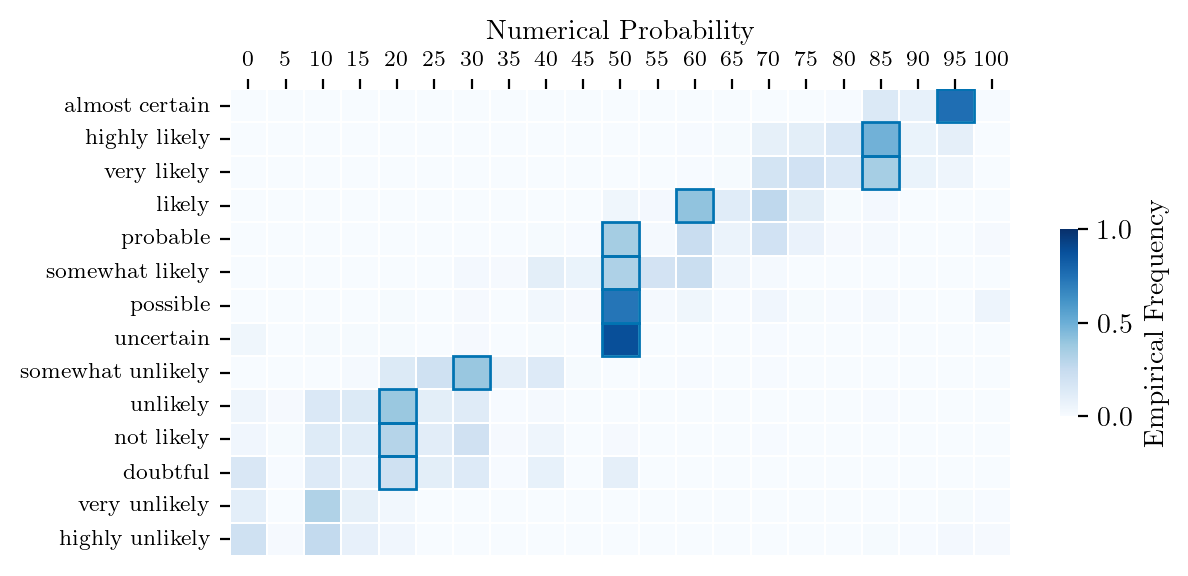

In [32]:
filepaths = sorted(glob.glob(f"{EVAL_DIR}/**/normalized.json", recursive=True))
print(len(filepaths), "histograms")
for path in filepaths:
    print_sep(path)
    
    fig, ax = plot_histogram(read_json(path), statistic="max")
    # ax.set_title(path)
    ax.set_xlabel("Numerical Probability")
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel(None)
    ax.tick_params(which="minor", bottom=False, left=False)

    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", fontsize=8)
    plt.setp(ax.get_yticklabels(), rotation=0, fontsize=8)

    name = path.rpartition("histogram_richer/")[-1]
    name = name.replace("/", "__").replace(".json","") + ".pdf"
    print(PLOTS_PATH(name))
    save_fig(fig, PLOTS_PATH(name))
    break


In [17]:
read_json(path)

{'almost certain': {'-1': 0.011194654352958985,
  '0.0': 0.0,
  '5.0': 0.0,
  '10.0': 0.0,
  '15.0': 0.0,
  '20.0': 0.0,
  '25.0': 0.0,
  '30.0': 0.0,
  '35.0': 0.0,
  '40.0': 0.0,
  '45.0': 0.0,
  '50.0': 0.0,
  '55.0': 0.0,
  '60.0': 0.0,
  '65.0': 0.0,
  '70.0': 1.3978859906536766e-07,
  '75.0': 1.9297220861642573e-06,
  '80.0': 8.500647148724301e-06,
  '85.0': 0.0004641197012288002,
  '90.0': 0.0038860266806089987,
  '95.0': 0.0011133652847211595,
  '100.0': 0.0},
 'control': {'-1': 0.0020142141053470747,
  '0.0': 8.584156027651637e-08,
  '5.0': 0.0,
  '10.0': 0.0,
  '15.0': 0.0,
  '20.0': 0.0,
  '25.0': 0.0,
  '30.0': 0.0,
  '35.0': 0.0,
  '40.0': 3.7112580001732026e-05,
  '45.0': 1.3875796851695137e-06,
  '50.0': 1.3803733357615693e-06,
  '55.0': 7.010112123713367e-06,
  '60.0': 2.4467695482020825e-05,
  '65.0': 0.00018079317452820388,
  '70.0': 0.0028280810763184803,
  '75.0': 0.008711102981382422,
  '80.0': 0.0015137627168777532,
  '85.0': 0.001335890908892659,
  '90.0': 4.5711

In [24]:
def compute_differences(hist1, hist2):
    common_keys = set(hist1.keys()).intersection(set(hist2.keys()))
    assert len(common_keys) == len(set(hist1.keys())) == len(set(hist2.keys()))

    results = {}
    for key in common_keys:
        results[key] = {}

        hist_keys = hist1[key].keys()
        for hist_key in hist_keys:
            results[key][hist_key] = hist1[key][hist_key] - hist2[key][hist_key]
    return results

filepaths = sorted(glob.glob(f"{EVAL_DIR}/**/normalized.json", recursive=True))

# Read human path
human_filepath = [fp for fp in filepaths if "humans" in fp][0]
human_histograms_by_unc = read_json(human_filepath)


hist_kwargs = dict(
            vmin=-1, vmax=1, cmap=sns.color_palette("vlag", as_cmap=True), linecolor='white', linewidth=0.01,
            annot=True,  fmt=".2f", annot_kws={"size":5},
        )
print(len(filepaths), "histograms")
for path in filepaths:
    print_sep(path)

    dist = read_json(path)
    dist_differences = compute_differences(human_histograms_by_unc, dist)
    fig, ax = plot_histogram(dist_differences, statistic=None, **hist_kwargs)
    ax.set_title(path)
    ax.set_xlabel("Numerical Probability")
    ax.set_ylabel("Uncertainty Expression")
    break
    name = path.rpartition("histogram_greedy/")[-1]
    name = name.replace("/", "__") + "__hist_differences_wrt_human__" + ".pdf"
    adjust(fig)
    save_fig(fig, PLOTS_PATH(name))

IndexError: list index out of range

## Create plot w/ differences for the male - female

18 histograms
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
../evals/results-2shot/json/histogram_greedy/gender/allenai/OLMo-7B-Instruct/male_normalized.json
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
../evals/results-2shot/json/histogram_greedy/gender/databricks/dbrx-instruct/male_normalized.json
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
../evals/results-2shot/json/histogram_greedy/gender/google/gemma-1.1-2b-it/male_normalized.json
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
../evals/results-2shot/json/histogram_greedy/gender/gpt-3.5-turbo-0125/male_normalized.json
+++++++++++++++++++++++++++++++++++

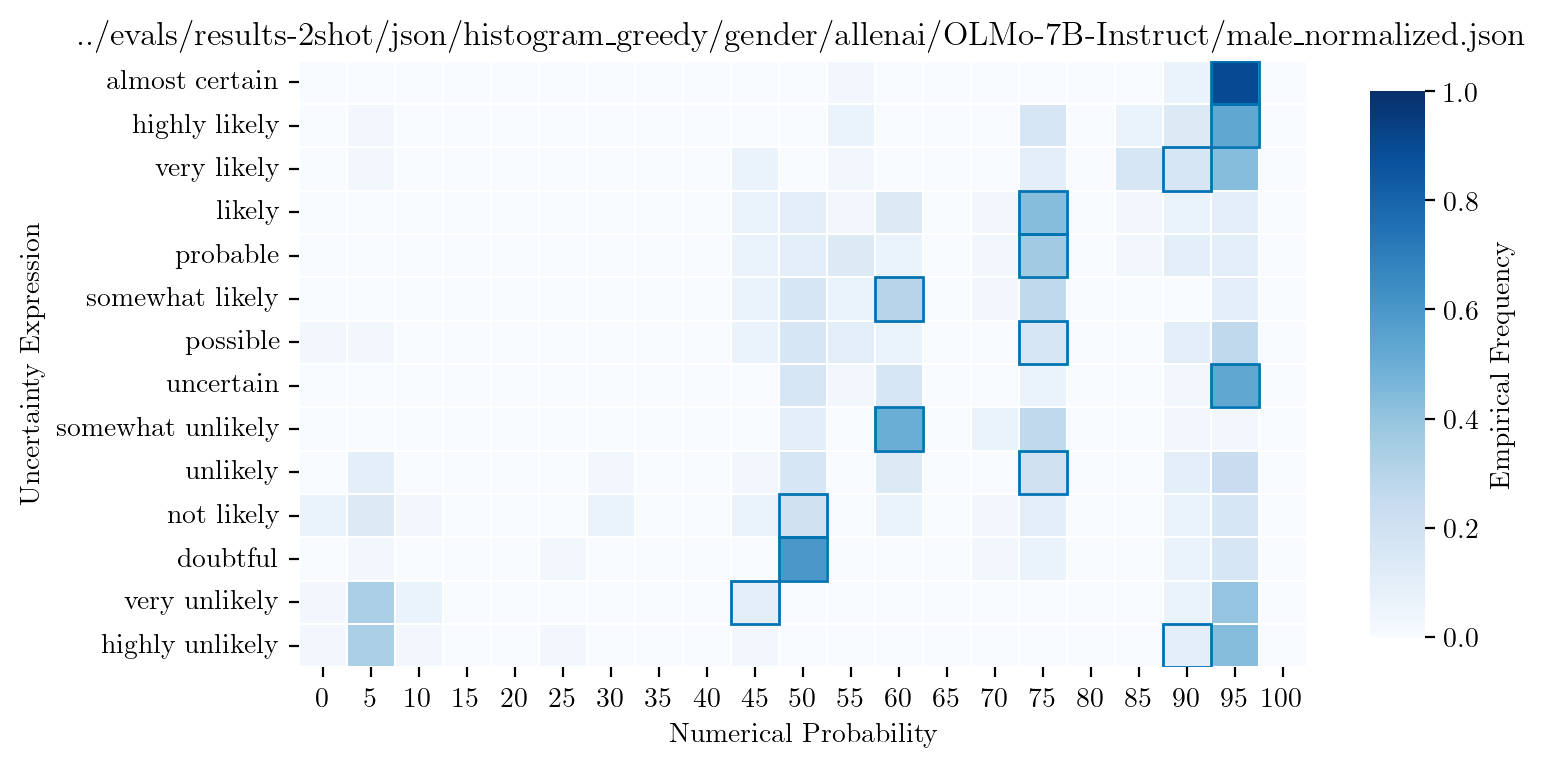

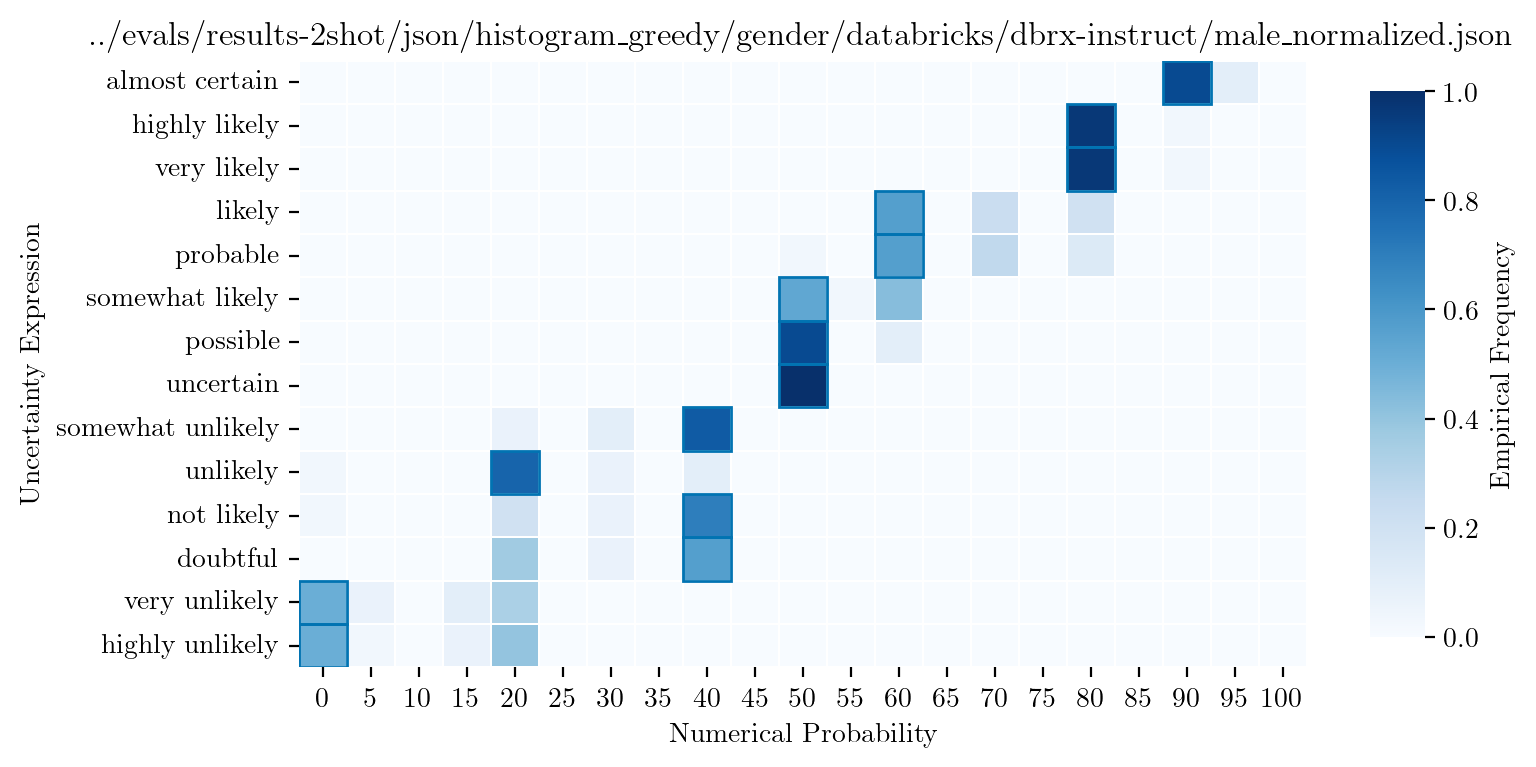

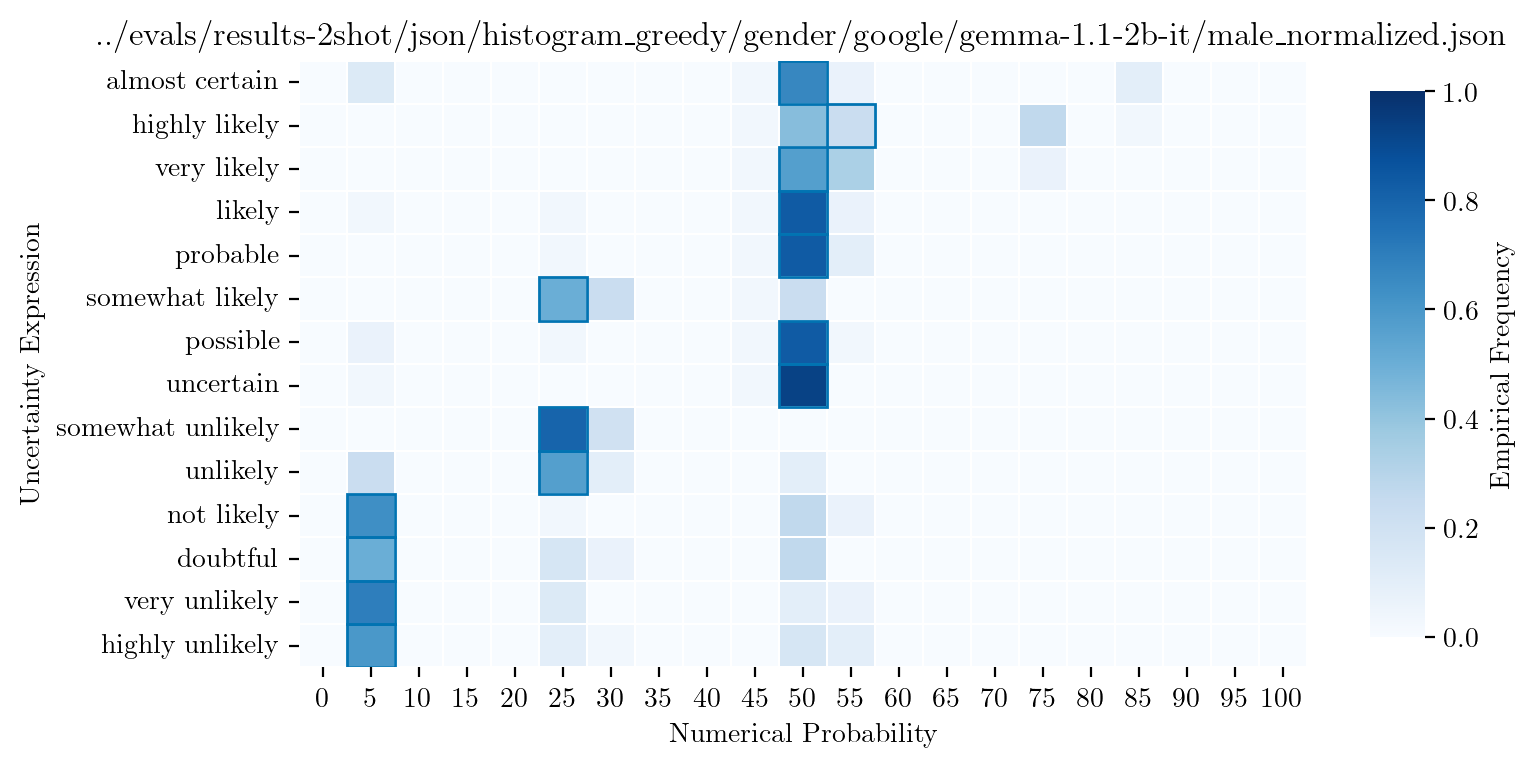

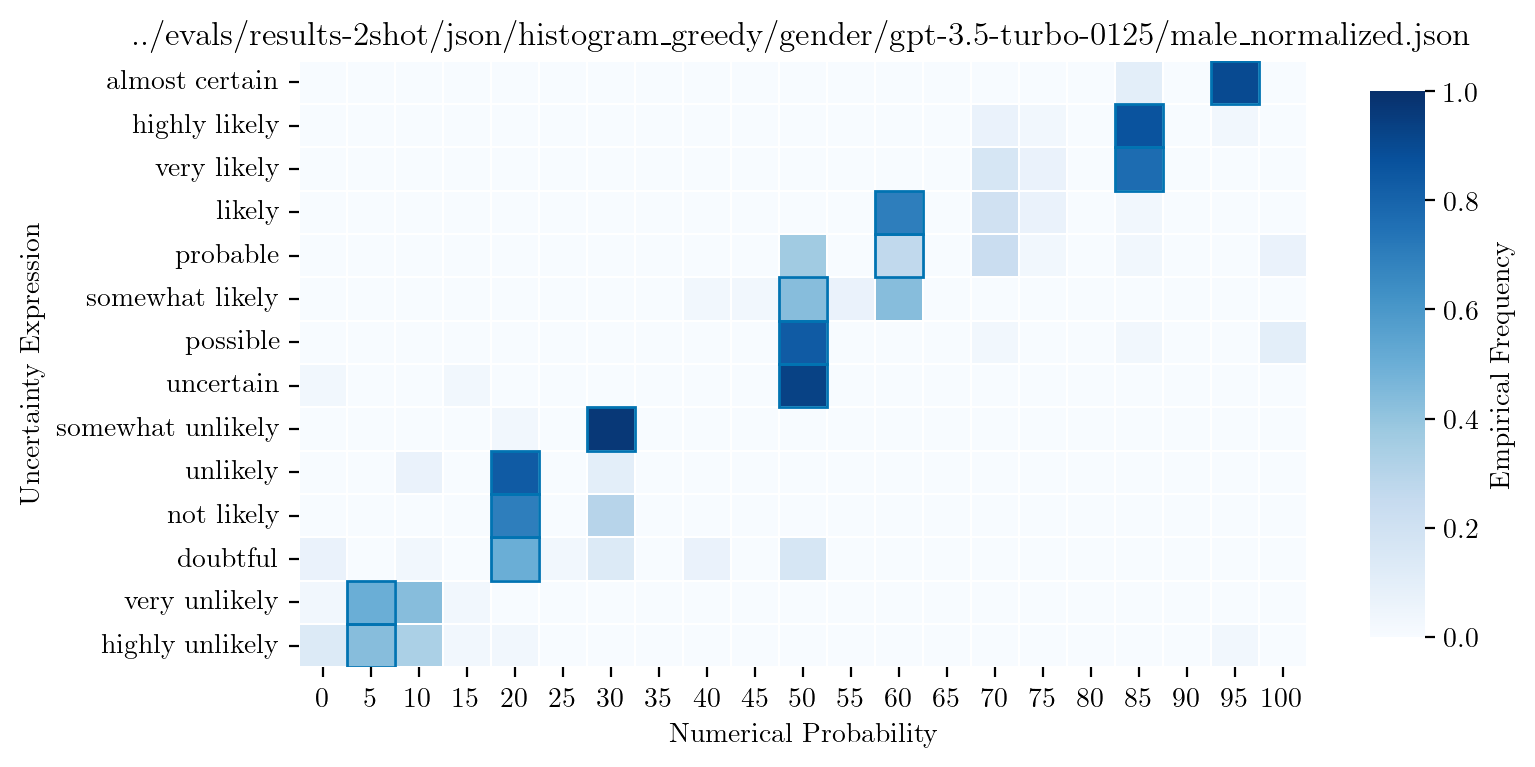

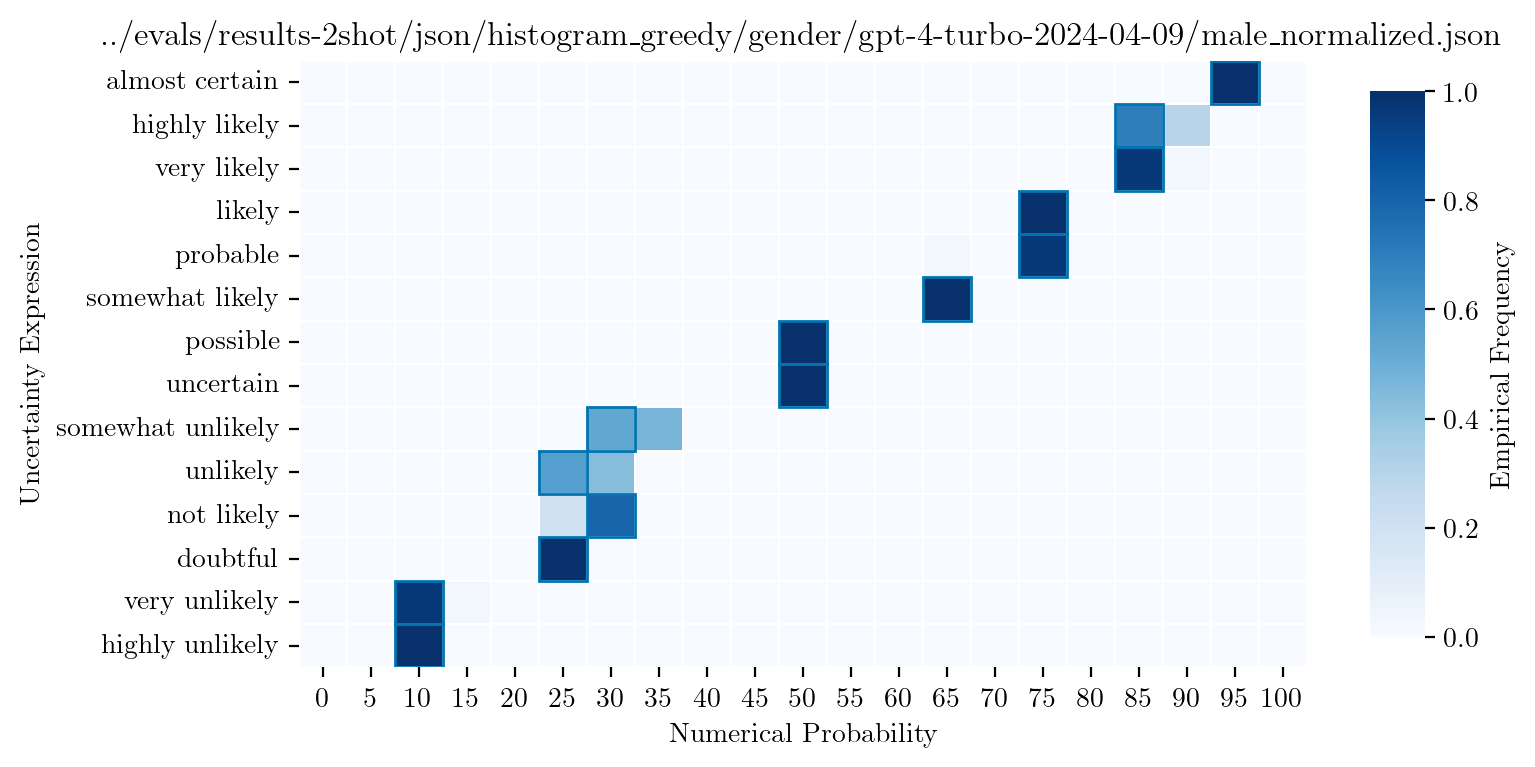

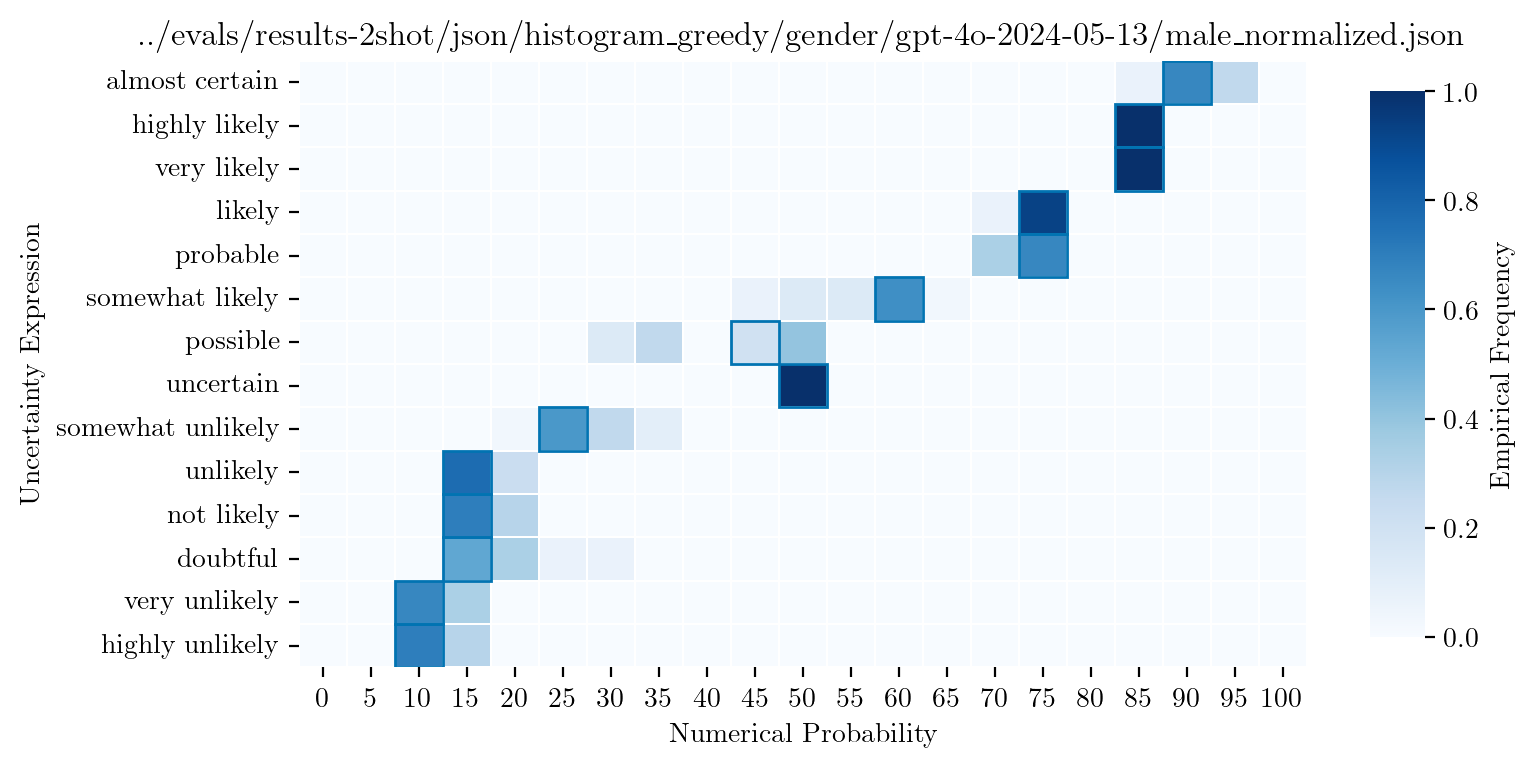

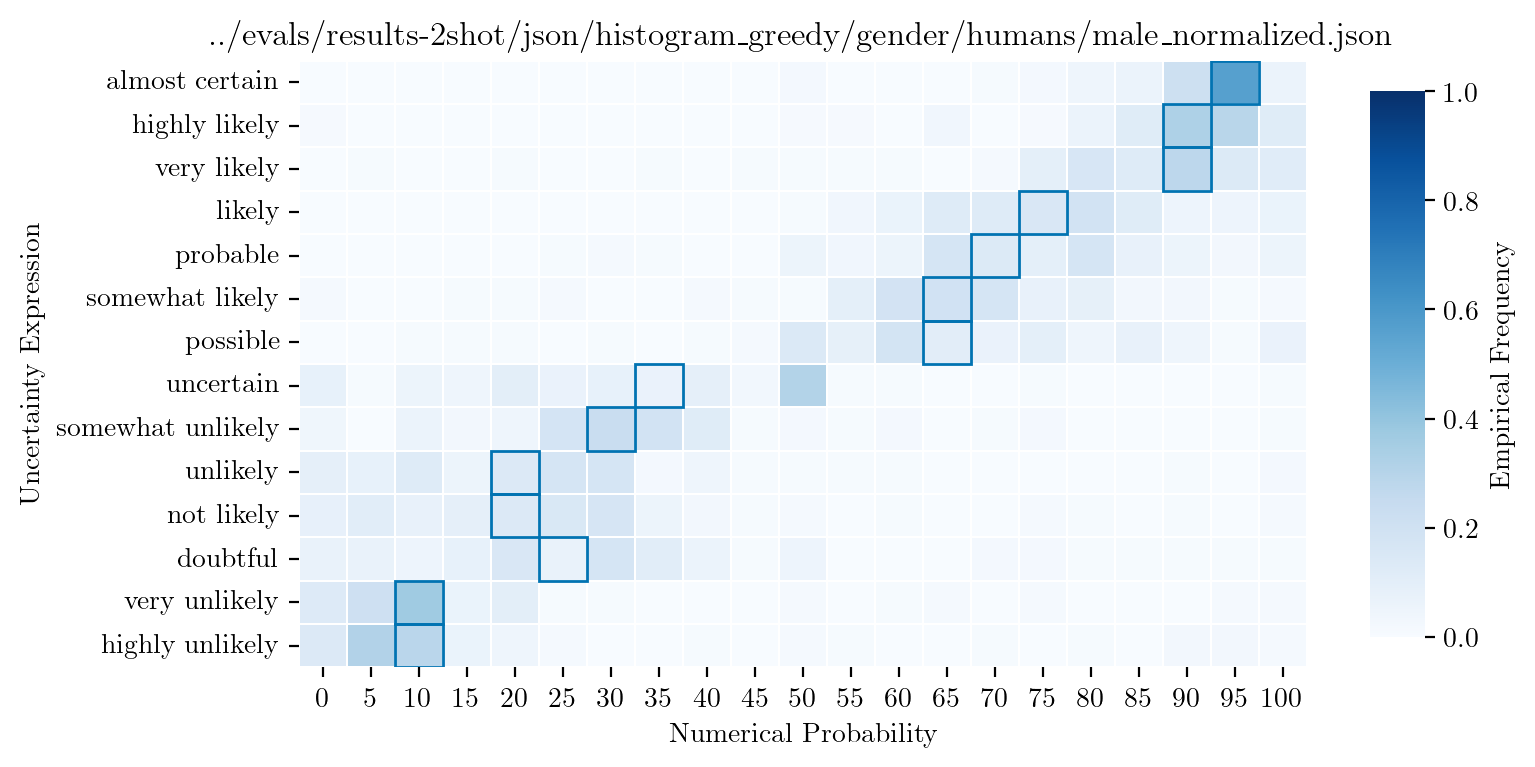

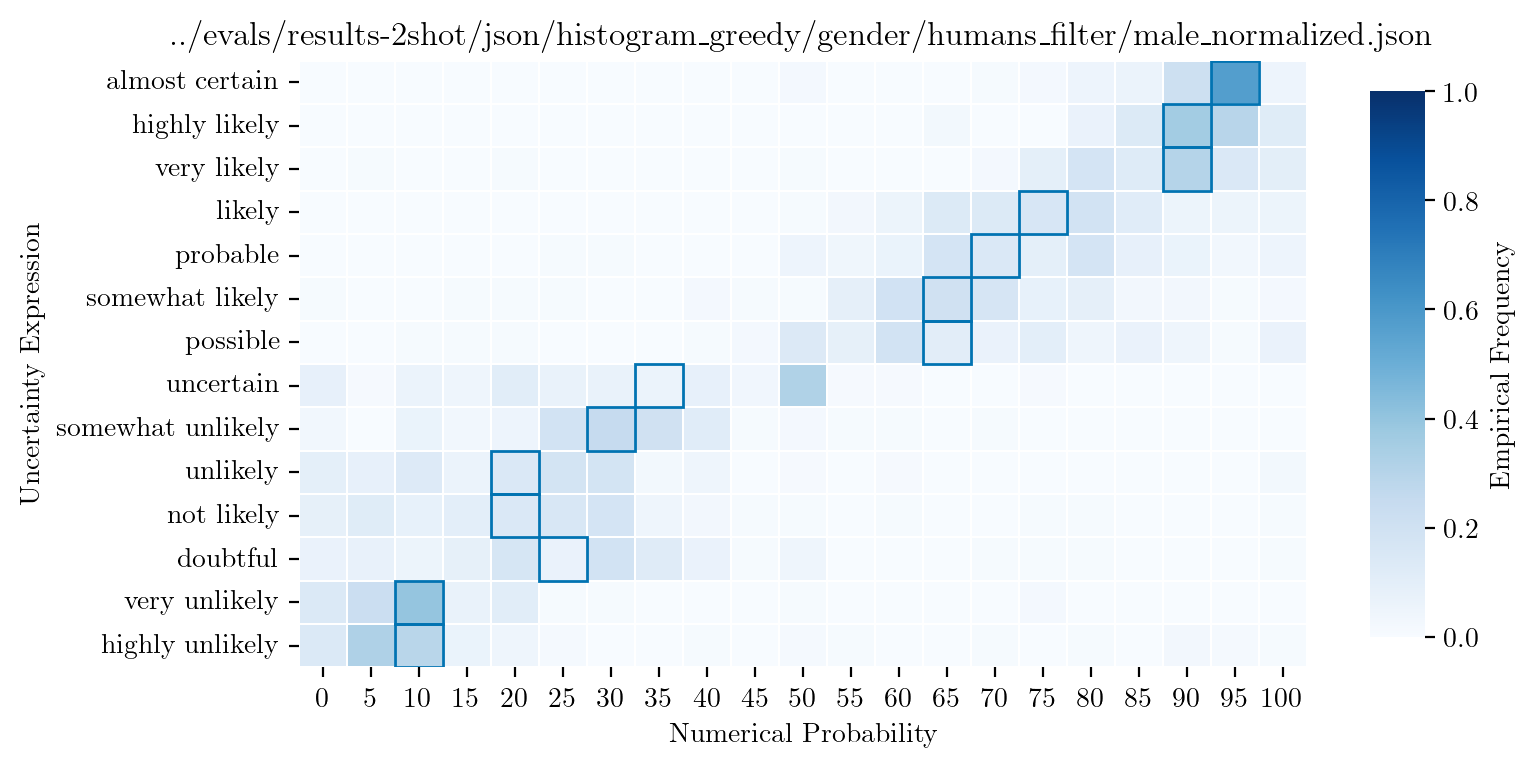

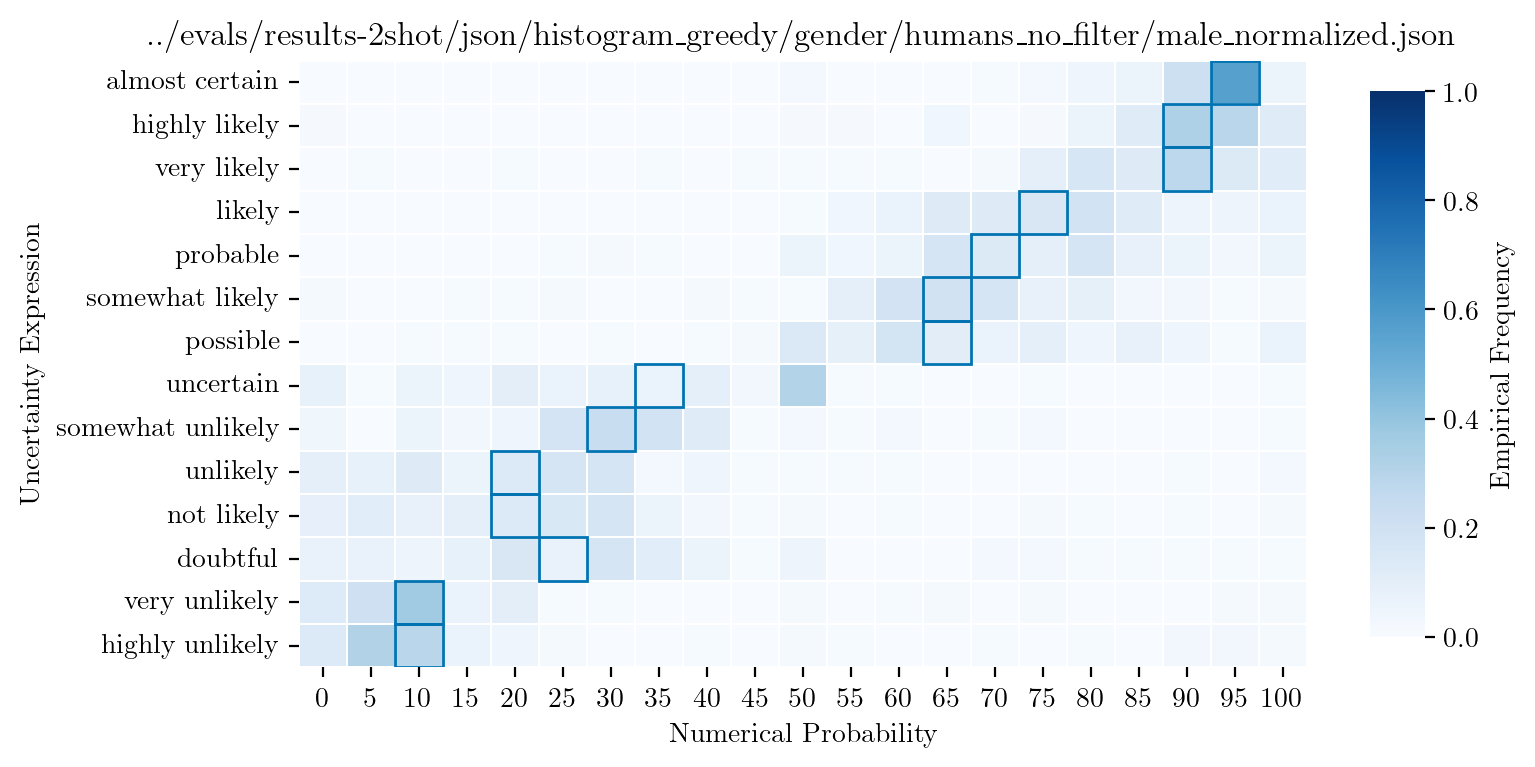

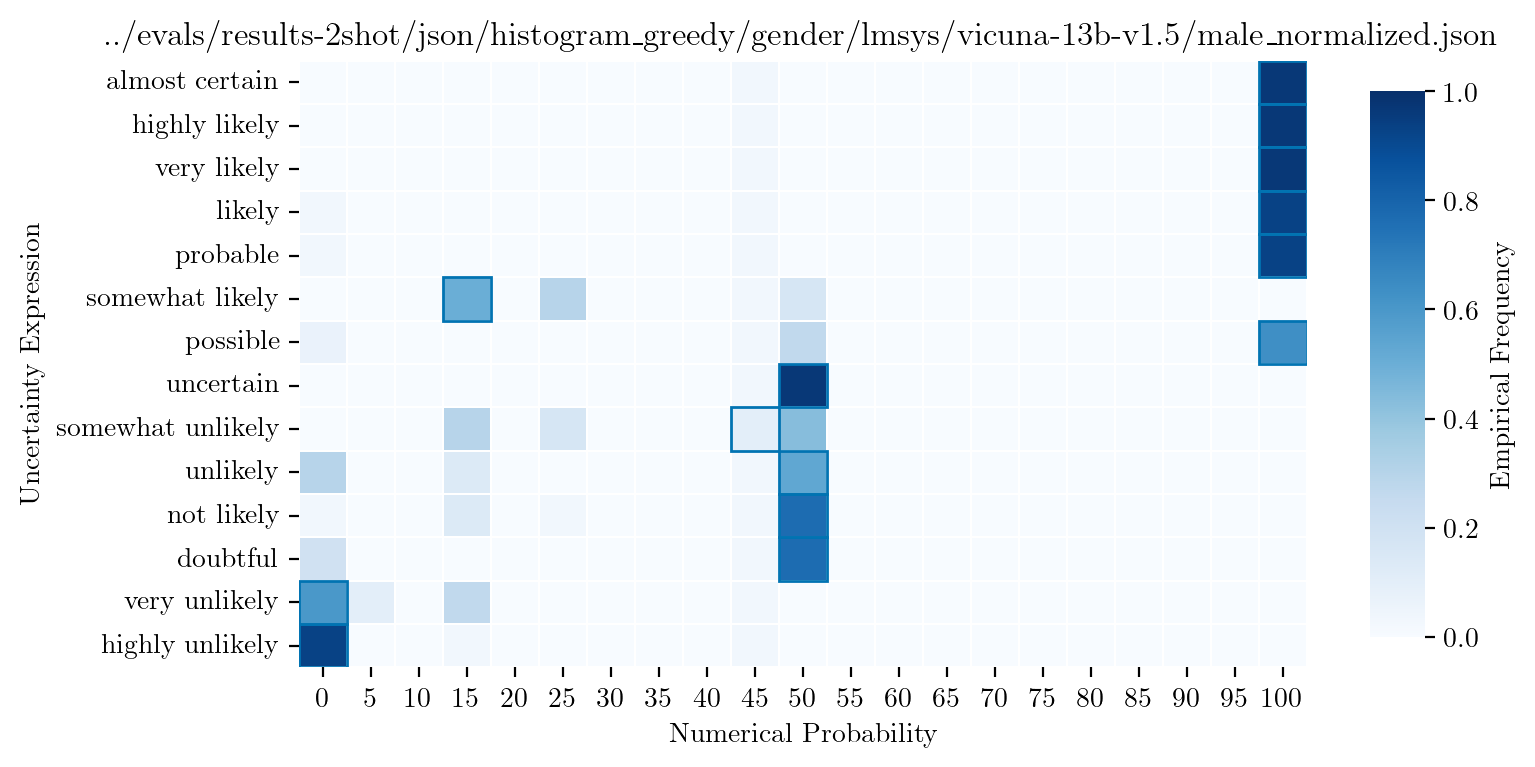

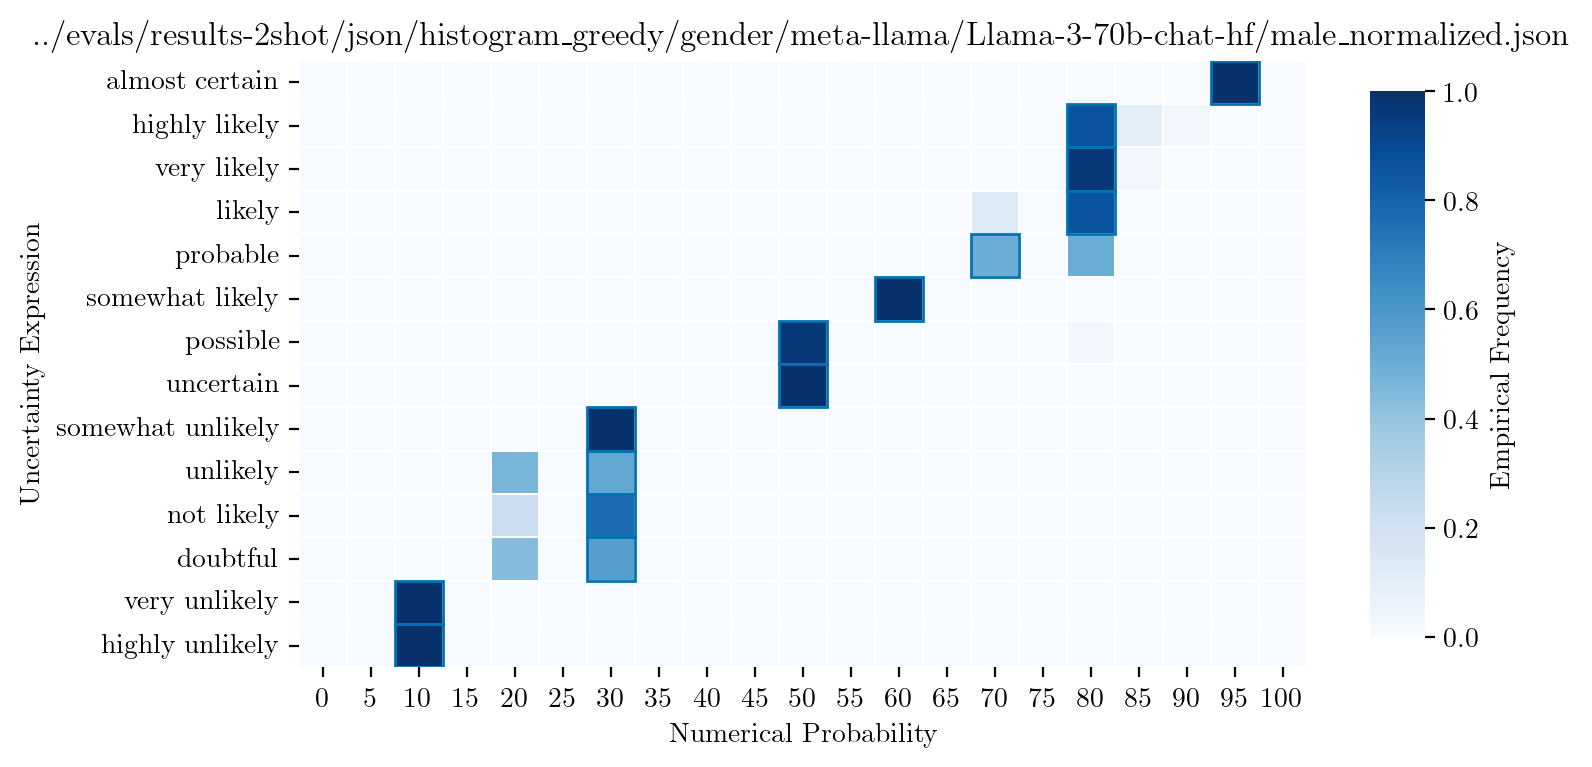

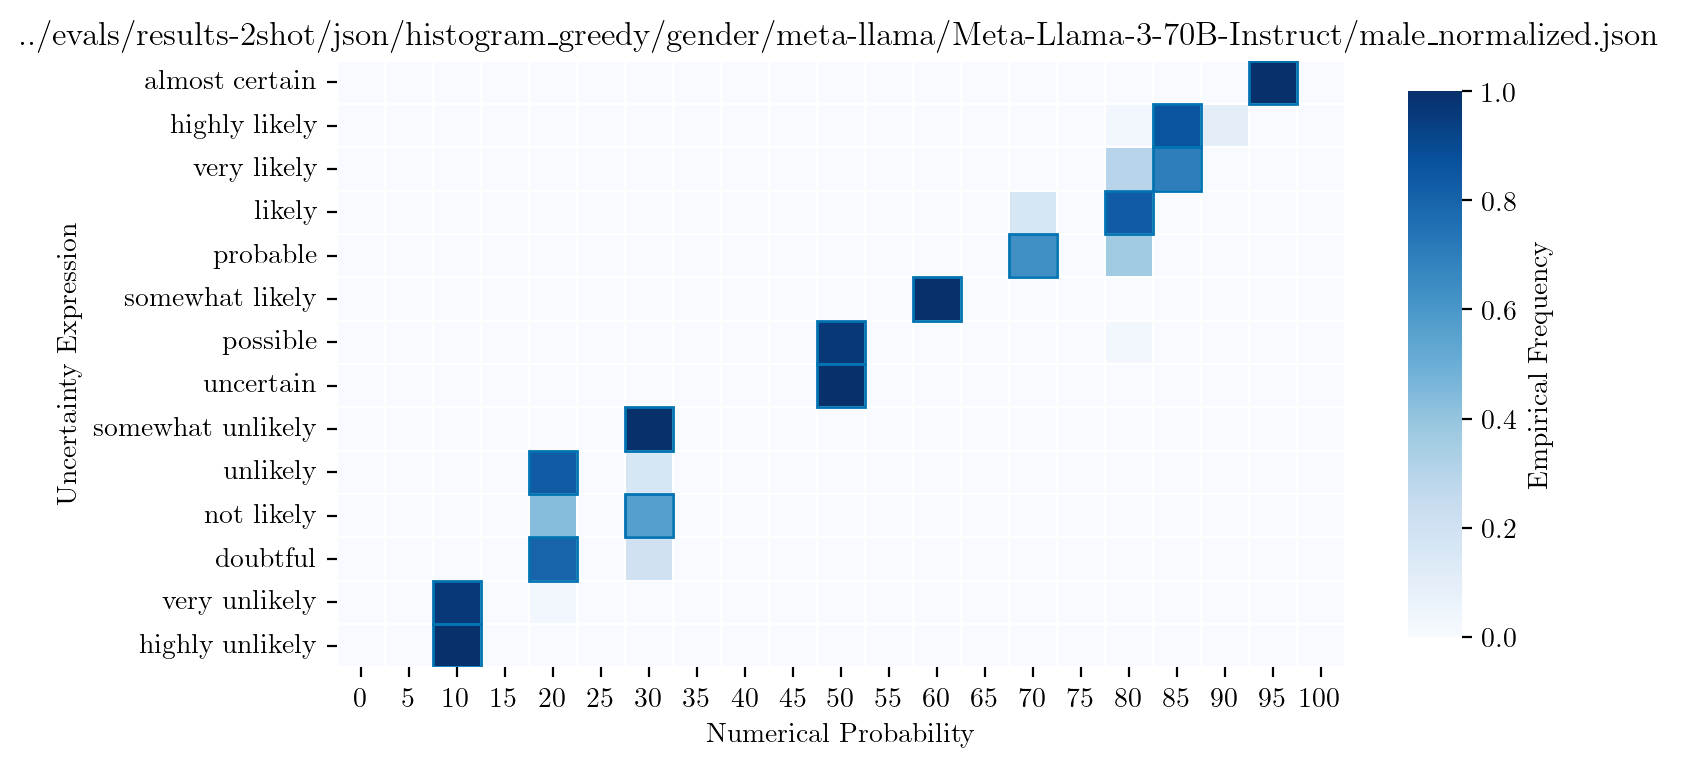

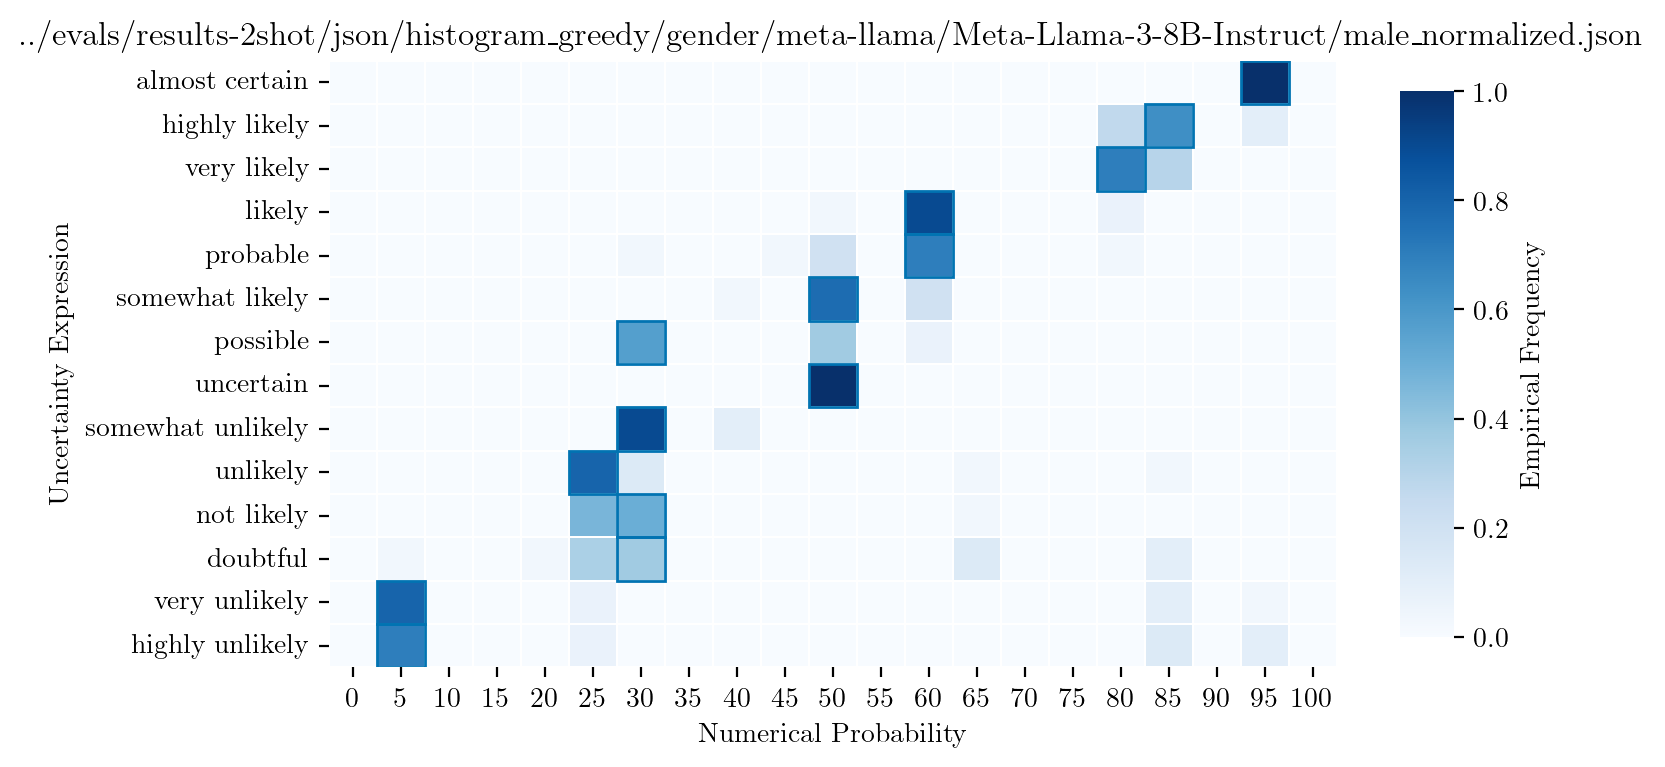

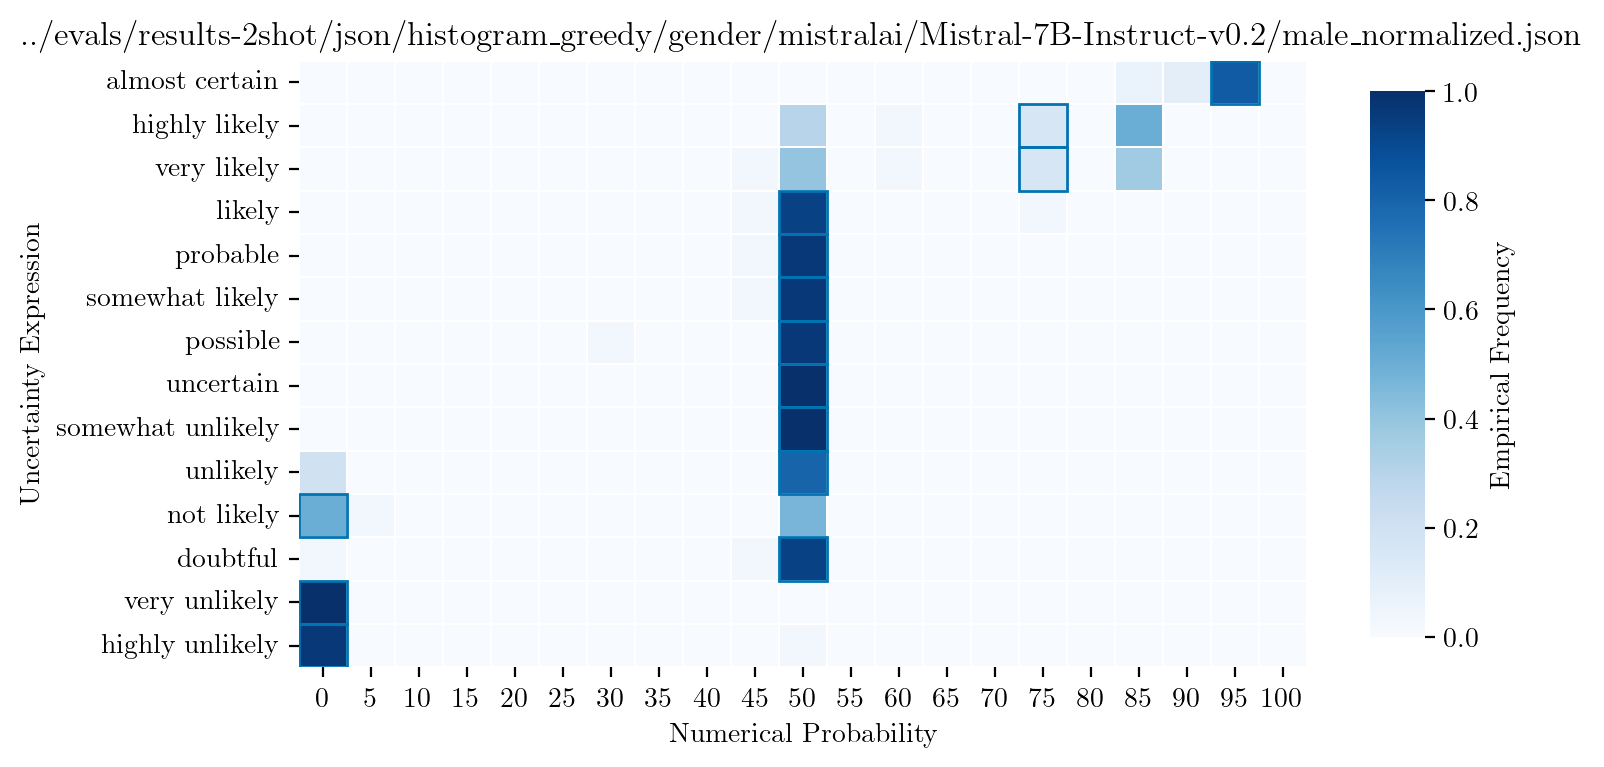

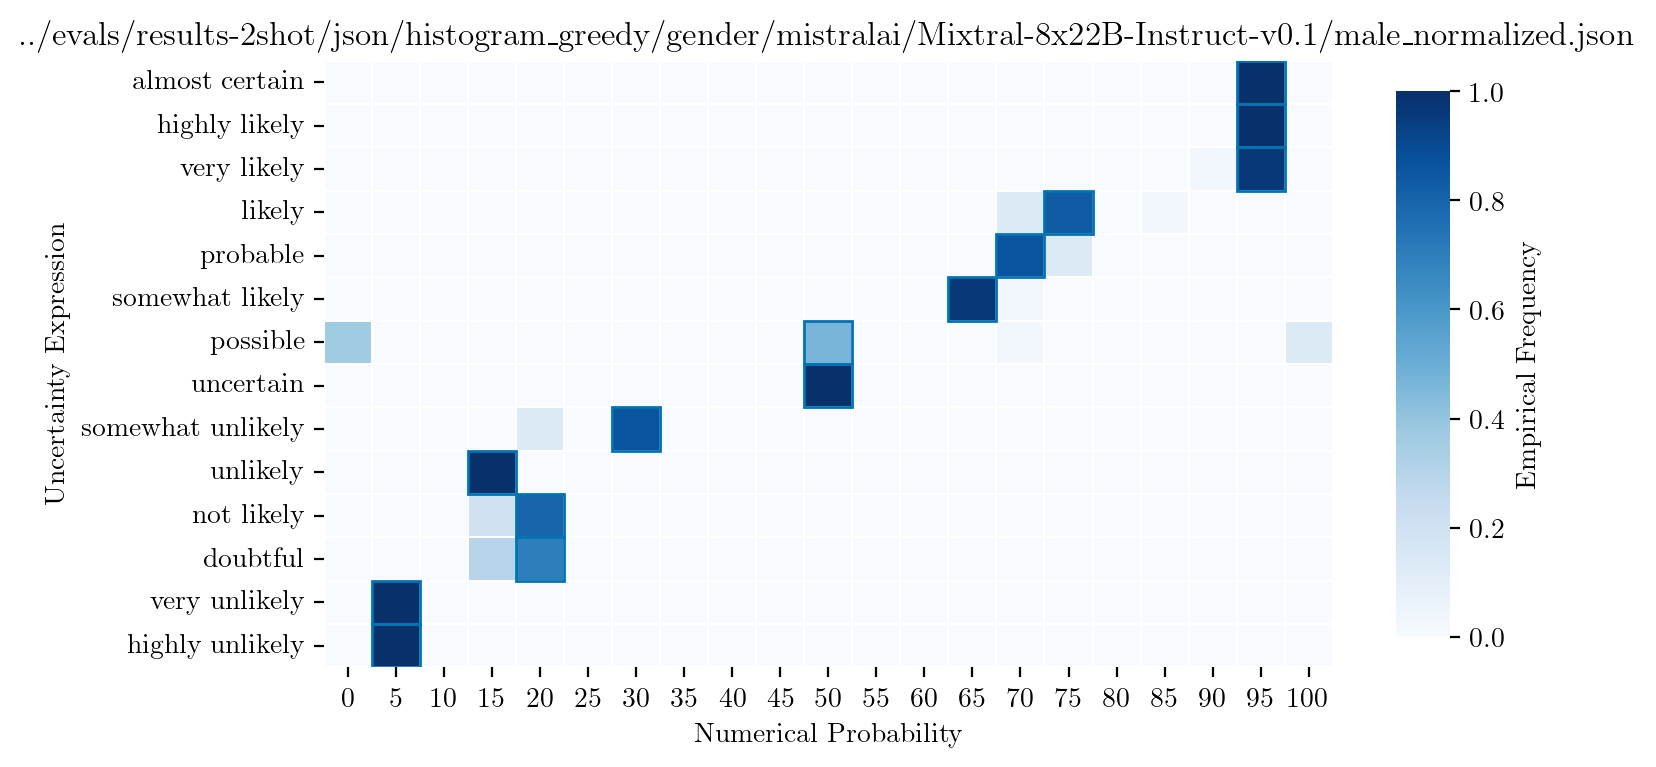

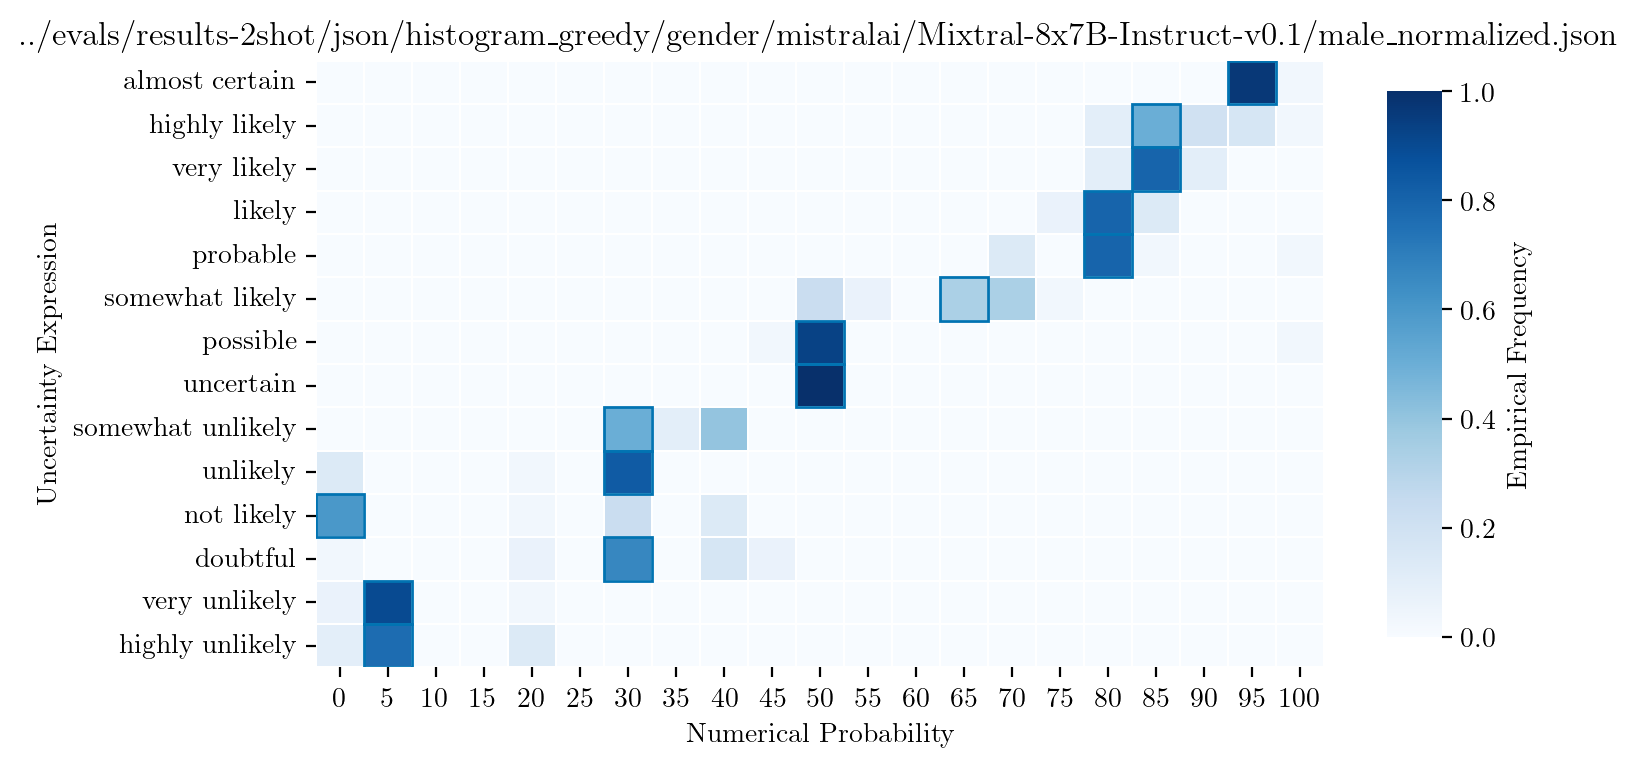

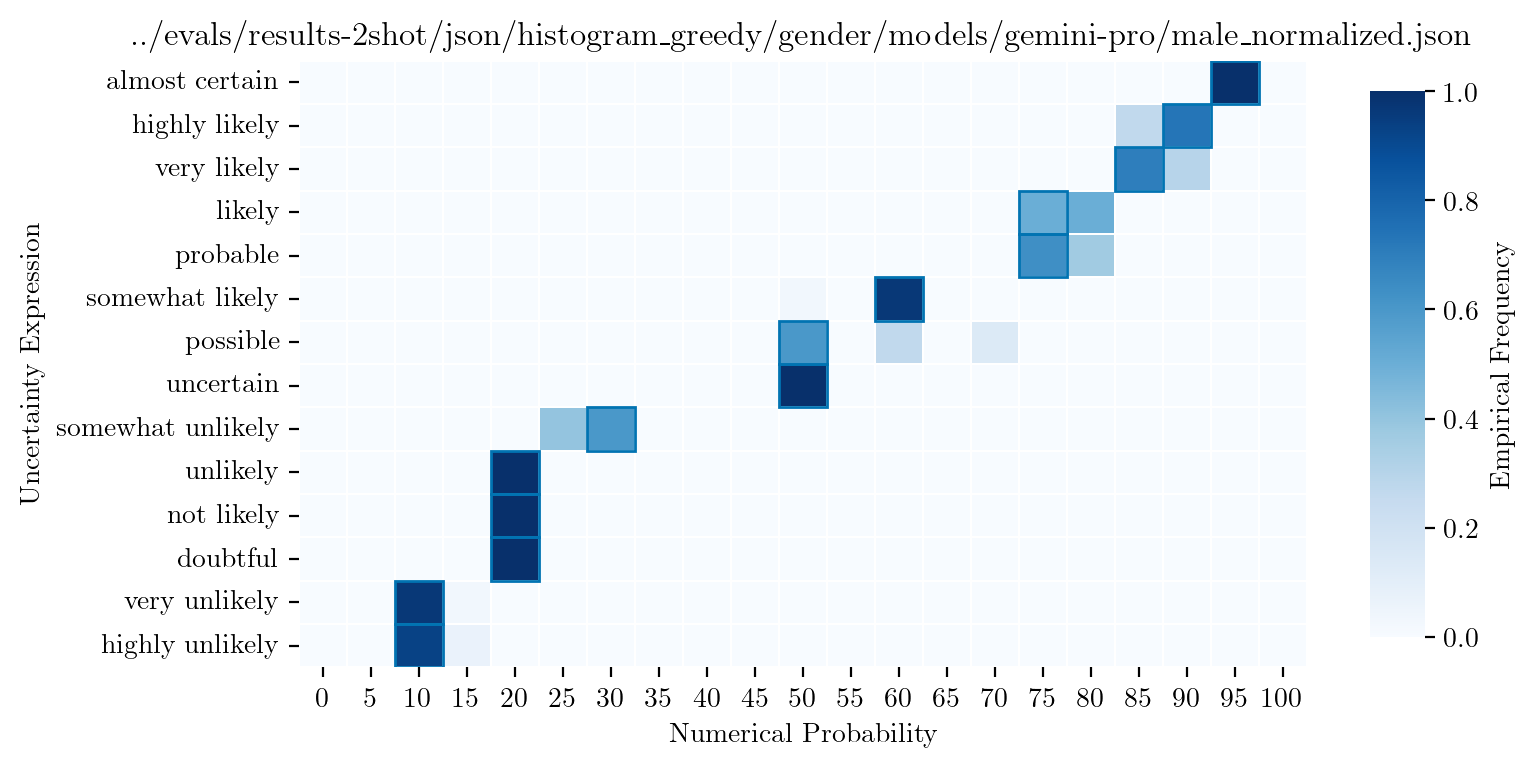

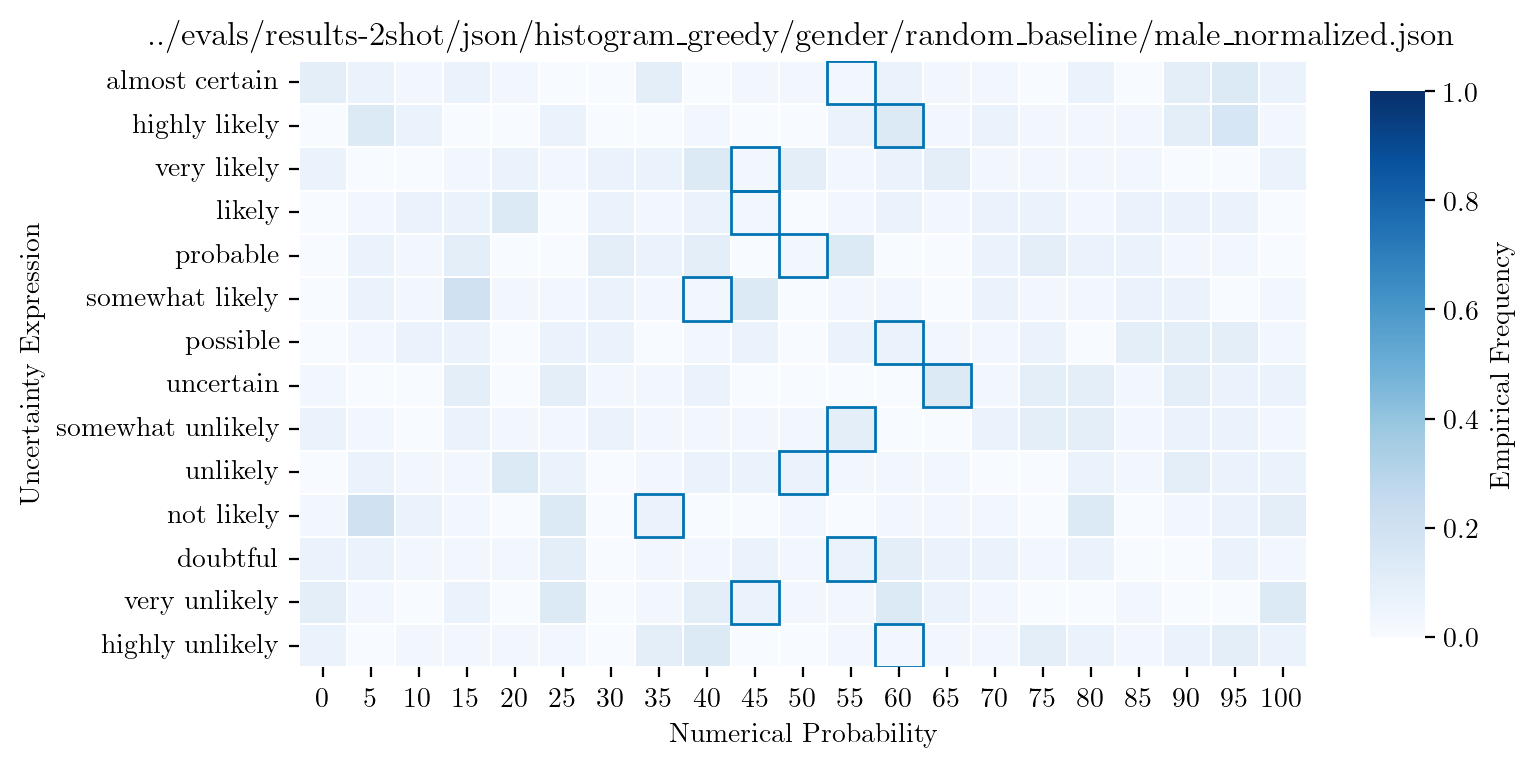

In [8]:
filepaths = sorted(glob.glob(f"{EVAL_DIR.replace('all', 'gender')}/**/male_normalized.json", recursive=True))
print(len(filepaths), "histograms")
for path in filepaths:
    print_sep(path)

    if not os.path.exists(path):
        continue

    fig, ax = plot_histogram(read_json(path), statistic="median")
    ax.set_title(path)
    ax.set_xlabel("Numerical Probability")
    ax.set_ylabel("Uncertainty Expression")

    name = path.rpartition("histogram_greedy/")[-1]
    name = name.replace("/", "__") + ".pdf"
    adjust(fig)
    save_fig(fig, PLOTS_PATH(name))

In [ ]:
filepaths = sorted(glob.glob(f"{EVAL_DIR.replace('all', 'gender')}/**/female_normalized.json", recursive=True))
print(len(filepaths), "histograms")
for path in filepaths:
    print_sep(path)

    if not os.path.exists(path):
        continue

    fig, ax = plot_histogram(read_json(path), statistic="median")
    ax.set_title(path)
    ax.set_xlabel("Numerical Probability")
    ax.set_ylabel("Uncertainty Expression")

    name = path.rpartition("histogram_greedy/")[-1]
    name = name.replace("/", "__") + ".pdf"
    adjust(fig)
    save_fig(fig, PLOTS_PATH(name))

In [ ]:
filepaths = sorted(glob.glob(f"{EVAL_DIR}/**/female_normalized.json", recursive=True))
print(len(filepaths), "histograms")
for path in filepaths:
    print_sep(path)

    if not os.path.exists(path):
        continue

    fig, ax = plot_histogram(read_json(path), statistic="median"))
    ax.set_title(path)
    ax.set_xlabel("Numerical Probability")
    ax.set_ylabel("Uncertainty Expression")

    name = path.rpartition("histogram_greedy/")[-1]
    name = name.replace("/", "__") + ".pdf"
    adjust(fig)
    save_fig(fig, PLOTS_PATH(name))

## Compute humans (NV) histogram

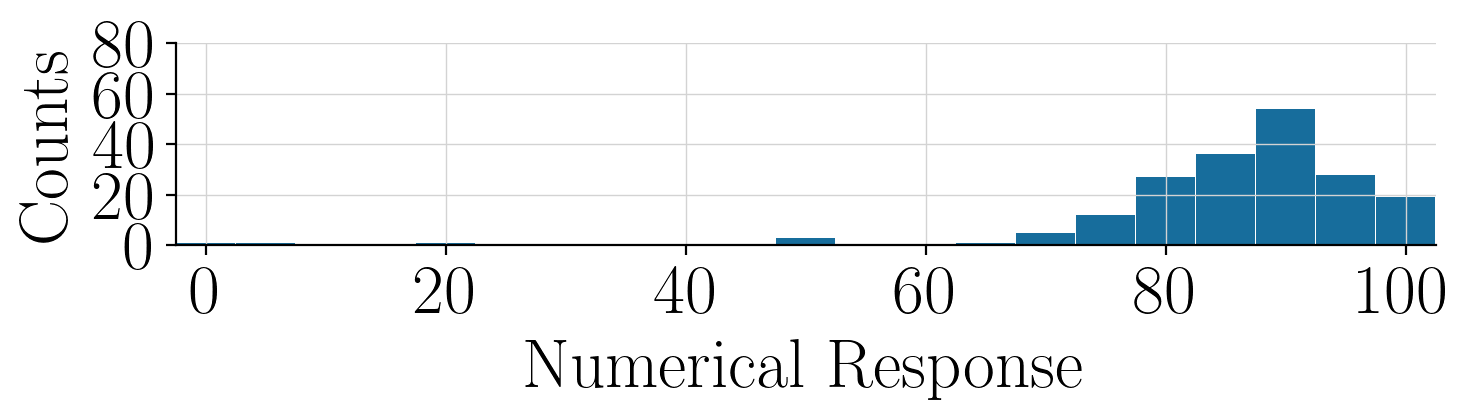

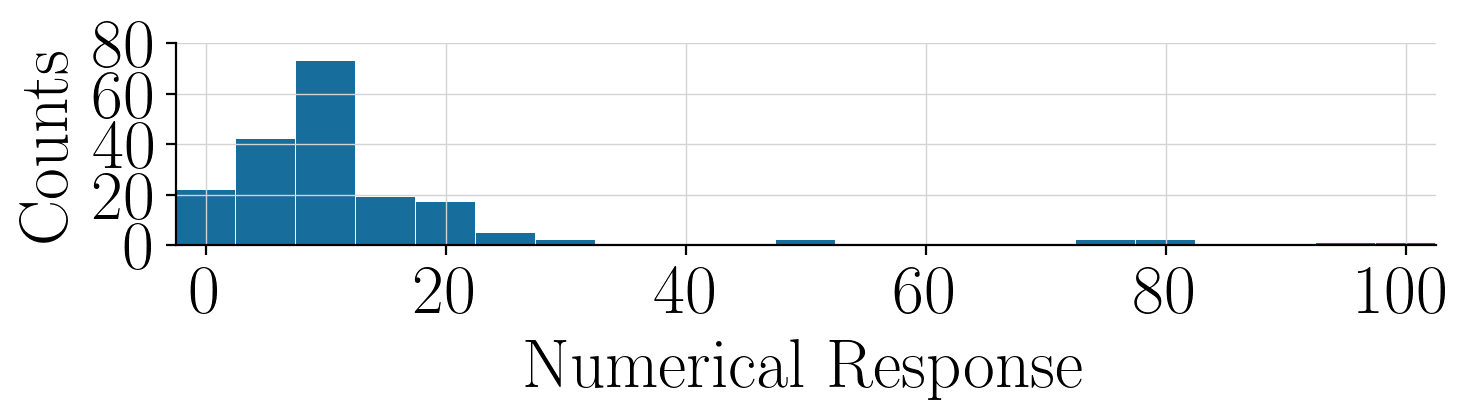

In [8]:
from matplotlib.ticker import MaxNLocator


# Put at top of plotting script (requires tex be installed though)
matplotlib.rc('font', family='serif', size=25)
matplotlib.rc('text', usetex=True)

humans_filepath = "../evals/results-2shot/json/histogram_greedy/all/humans_filter/unnormalized.json"
humans_dist = read_json(humans_filepath)


for i, unc in enumerate(["very likely", "very unlikely"]):
    expr = humans_dist[unc]
    expr.pop("-1")

    fig, ax = plt.subplots(1, 1, figsize=(FULL_WIDTH, FULL_HEIGHT/3), dpi=200)

    numerical_responses, counts = zip(*expr.items())
    numerical_responses = [int(float(r)) for r in numerical_responses]
    sns.barplot(x=numerical_responses, y=counts, ax=ax, width=0.99)
    ax.spines[['right', 'top']].set_visible(False)
    
    ax.xaxis.set_major_locator(MultipleLocator(4))
    ax.yaxis.set_major_locator(MultipleLocator(20))
    
    ax.grid(axis='x', which="major", linewidth=0.5, linestyle='-', color="lightgray")
    ax.grid(axis='y', which="major", linewidth=0.5, linestyle='-', color="lightgray")
    
    ax.set_ylabel("Counts")
    ax.set_xlabel("Numerical Response")
    ax.set_ylim(0, 80)

    adjust(fig)
    save_fig(fig, f"../evals/results-2shot/analysis/human_histograms__{unc}.pdf")

In [83]:
numerical_responses

[0,
 5,
 10,
 15,
 20,
 25,
 30,
 35,
 40,
 45,
 50,
 55,
 60,
 65,
 70,
 75,
 80,
 85,
 90,
 95,
 100]

In [26]:
PLOTS_PATH("humans")

'../evals/results-2shot/json/histogram_greedy/all/analysis/plots/humans'

In [106]:
from matplotlib.ticker import MaxNLocator


# Put at top of plotting script (requires tex be installed though)
matplotlib.rc('font', family='serif', size=20)
matplotlib.rc('text', usetex=True)

humans_filepath = "../evals/results-2shot/csv/histogram_greedy/all/humans_filter/unnormalized.csv"
humans_dist = pd.read_csv(humans_filepath, index_col=0).drop('-1.0', axis=1)
humans_dist = humans_dist.reset_index().rename({"index": "uncertainty"}, axis=1)
humans_dist = humans_dist.melt(id_vars=["uncertainty"], var_name="numerical response", value_name="counts")
humans_dist

,uncertainty,numerical response,counts
0,control,0.0,0
1,almost certain,0.0,1
2,highly likely,0.0,2
3,very likely,0.0,1
4,probable,0.0,0
...,...,...,...
310,unlikely,100.0,2
311,not likely,100.0,1
312,doubtful,100.0,1
313,very unlikely,100.0,1


In [110]:
humans_dist["counts"].apply(lambda x: [1] * x
explode("counts")

,uncertainty,numerical response,counts
0,control,0.0,0
1,almost certain,0.0,1
2,highly likely,0.0,2
3,very likely,0.0,1
4,probable,0.0,0
...,...,...,...
310,unlikely,100.0,2
311,not likely,100.0,1
312,doubtful,100.0,1
313,very unlikely,100.0,1


In [98]:
humans_dist.columns

Index(['0.0', '5.0', '10.0', '15.0', '20.0', '25.0', '30.0', '35.0', '40.0',
       '45.0', '50.0', '55.0', '60.0', '65.0', '70.0', '75.0', '80.0', '85.0',
       '90.0', '95.0', '100.0', '-1.0'],
      dtype='object')